<a href="https://colab.research.google.com/github/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/blob/main/notebooks/00_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fase 1: Análisis Exploratorio de datos

#### **Elección y descripción del Conjunto de datos**

Para el desarrollo de esta actividad se seleccionó el dataset [“Power consumption of Tetouan city”](https://archive.ics.uci.edu/dataset/849/power+consumption+of+tetouan+city), disponible en el repositorio de la UCI Machine Learning Repository. Este conjunto de datos recopila mediciones de consumo eléctrico en tres zonas diferentes de la ciudad de Tetuán (Marruecos), registradas a intervalos de 10 minutos, durante el período comprendido entre enero de 2017 y diciembre de 2017.

Además del consumo eléctrico en cada zona, el dataset incluye variables meteorológicas como **temperatura, humedad, velocidad del viento y condiciones generales del clima**, lo cual lo convierte en un conjunto idóneo para el análisis de series de tiempo con variables exógenas.

La elección de este dataset se fundamenta en que el **consumo energético es un problema real, complejo y de alto impacto social y económico**, siendo de gran relevancia para las ciudades que buscan optimizar la distribución eléctrica y garantizar la sostenibilidad de la red. La disponibilidad de múltiples variables adicionales permite enriquecer los modelos de predicción, mejorando la capacidad de capturar patrones estacionales, tendencias y la influencia de factores externos.

En consecuencia, este conjunto de datos representa una oportunidad para aplicar y comparar distintos enfoques de modelado de series de tiempo, desde modelos estadísticos clásicos (ARIMA, SARIMA) hasta redes neuronales recurrentes y convolucionales, evaluando la importancia de las variables exógenas en la mejora de las predicciones.


In [6]:
import requests
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from io import BytesIO
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
# Importar datos
DATA_GITHUB_URL = 'https://raw.githubusercontent.com/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/refs/heads/main/data/power%2Bconsumption%2Bof%2Btetouan%2Bcity/Tetuan%20City%20power%20consumption.csv'

# Descargar los datos desde github
response = requests.get(DATA_GITHUB_URL)

# Convertir en un df desde el xlsx de github
df = pd.read_csv(BytesIO(response.content), sep=',')

# Formato de columnas
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df = df.dropna(subset=['DateTime']) # Eliminar filas con DateTime inválido (NaT)

# Transformar columnas
df.columns = df.columns.str.strip()
df.columns = df.columns.str.lower()
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

rename_dict = {
    'zone_1_power_consumption': 'zone_1',
    'zone_2__power_consumption': 'zone_2',
    'zone_3__power_consumption': 'zone_3'
}

df.rename(columns=rename_dict, inplace=True)

---

#### **Planteamiento de la problemática**

**Problemática planteada:**

El objetivo es predecir el consumo eléctrico en la Zona 1 de la ciudad de Tetuán con horizonte de corto plazo (10 minutos – varias horas). Esto permite anticipar la demanda energética en tiempo real y a nivel granular, considerando que el consumo depende de factores exógenos como la temperatura, la humedad y la velocidad del viento.

**Importancia de la predicción:**

1. **Planificación de la red eléctrica:** conocer de antemano los picos de consumo ayuda a las empresas distribuidoras a equilibrar la carga, evitando sobrecargas que podrían causar apagones.
2. **Optimización de costos:** las compañías eléctricas pueden gestionar mejor la compra de energía en el mercado mayorista, reduciendo gastos innecesarios.
3. **Integración de energías renovables:** predecir la demanda facilita ajustar la producción, especialmente si la ciudad incorpora fuentes variables como la solar o la eólica.
4. **Eficiencia operativa y ambiental:** una predicción más precisa disminuye la necesidad de generación de respaldo con combustibles fósiles, contribuyendo a la sostenibilidad.

En síntesis, el problema es relevante porque un **pronóstico confiable del consumo eléctrico** no solo garantiza la estabilidad del suministro, sino que también mejora la eficiencia económica y medioambiental del sistema energético de la ciudad.



---

#### **Analisis de la serie de tiempo**

##### La primera pregunta es ¿Con cuál zona deberíamos trabajar?

In [8]:
# Selección de columnas por zonas
zonas = ["zone_1", "zone_2", "zone_3"]
clima = ["temperature", "humidity", "wind_speed", "general_diffuse_flows", "diffuse_flows"]

resultados = []

for z in zonas:
    zona_df = df[z]

    # 1. Valores faltantes
    missing = zona_df.isna().sum()

    # 2. Consumo promedio y desviación estándar
    mean_val = zona_df.mean()
    std_val = zona_df.std()

    # 3. Correlación con clima
    corr = df[clima].corrwith(zona_df).abs().mean()

    resultados.append({
        "Zona": z,
        "Faltantes": missing,
        "Consumo_Promedio": mean_val,
        "Variabilidad": std_val,
        "Correlacion_Clima": corr
    })

# Convertimos a dataframe para comparar
resumen = pd.DataFrame(resultados)

# Normalizamos valores para compararlos (0 a 1)
for col in ["Faltantes", "Consumo_Promedio", "Variabilidad", "Correlacion_Clima"]:
    if col == "Faltantes":
        max_val = resumen[col].max()
        if max_val == 0:
            resumen[col + "_Score"] = 1.0  # todas perfectas en faltantes
        else:
            resumen[col + "_Score"] = 1 - (resumen[col] / max_val)
    else:
        max_val = resumen[col].max()
        if max_val == 0:
            resumen[col + "_Score"] = 0.0
        else:
            resumen[col + "_Score"] = resumen[col] / max_val


# Score final ponderado (puedes ajustar los pesos según importancia)
resumen["Score_Final"] = (
    0.3 * resumen["Consumo_Promedio_Score"] +
    0.2 * resumen["Variabilidad_Score"] +
    0.3 * resumen["Correlacion_Clima_Score"] +
    0.2 * resumen["Faltantes_Score"]
)

# Reemplazar NaN por 0 en los scores
resumen = resumen.fillna(0)

# Seleccionamos la mejor zona
mejor_zona = resumen.loc[resumen["Score_Final"].idxmax()]

print("Resultados comparativos:")
print(resumen)
print("\nLa mejor zona elegida es:", mejor_zona["Zona"])


Resultados comparativos:
     Zona  Faltantes  Consumo_Promedio  Variabilidad  Correlacion_Clima  \
0  zone_1          0      32344.970564   7130.562564           0.232665   
1  zone_2          0      21042.509082   5201.465892           0.205139   
2  zone_3          0      17835.406218   6622.165099           0.220614   

   Faltantes_Score  Consumo_Promedio_Score  Variabilidad_Score  \
0              1.0                1.000000            1.000000   
1              1.0                0.650565            0.729461   
2              1.0                0.551412            0.928702   

   Correlacion_Clima_Score  Score_Final  
0                 1.000000     1.000000  
1                 0.881692     0.805569  
2                 0.948206     0.835626  

La mejor zona elegida es: zone_1


Con el fin de desarrollar un modelo predictivo de consumo eléctrico confiable, se evaluaron las tres zonas incluidas en el conjunto de datos: **zone\_1, zone\_2 y zone\_3**. La selección de la zona más adecuada se fundamentó en un análisis comparativo basado en cuatro criterios principales:

1. **Calidad de los datos (faltantes):** se verificó la presencia de valores nulos o incompletos. Una menor proporción de faltantes asegura una mayor robustez en la modelación.
2. **Consumo promedio:** refleja la magnitud y relevancia del consumo eléctrico en cada zona. Valores más altos resultan más representativos para el estudio.
3. **Variabilidad del consumo:** permite identificar la dinámica y fluctuaciones en la demanda. Una mayor dispersión posibilita capturar patrones más complejos durante el entrenamiento de modelos.
4. **Correlación con variables climáticas:** se analizó la relación entre el consumo y factores meteorológicos como temperatura, humedad y velocidad del viento. Una mayor correlación evidencia la posibilidad de explicar el consumo a partir de variables externas.

Para homogeneizar la comparación, cada criterio fue normalizado en un rango de **0 a 1** y posteriormente agregado en un **índice de desempeño global (Score\_Final)**.

Los resultados mostraron que **zone\_1** obtuvo los valores más favorables en consumo promedio, variabilidad y correlación climática, manteniendo además una calidad de datos adecuada sin registros faltantes. En contraste, **zone\_2** y **zone\_3** presentaron menor consumo y correlaciones más débiles con las variables climáticas.

Por lo anterior, se concluye que la **zona seleccionada para el análisis predictivo es Zone\_1**, al ser la que reúne las condiciones óptimas de relevancia, variabilidad y explicabilidad para la construcción de modelos de predicción de consumo eléctrico en la ciudad de Tetuán.

---

#### **Elección de Variables Exógenas**

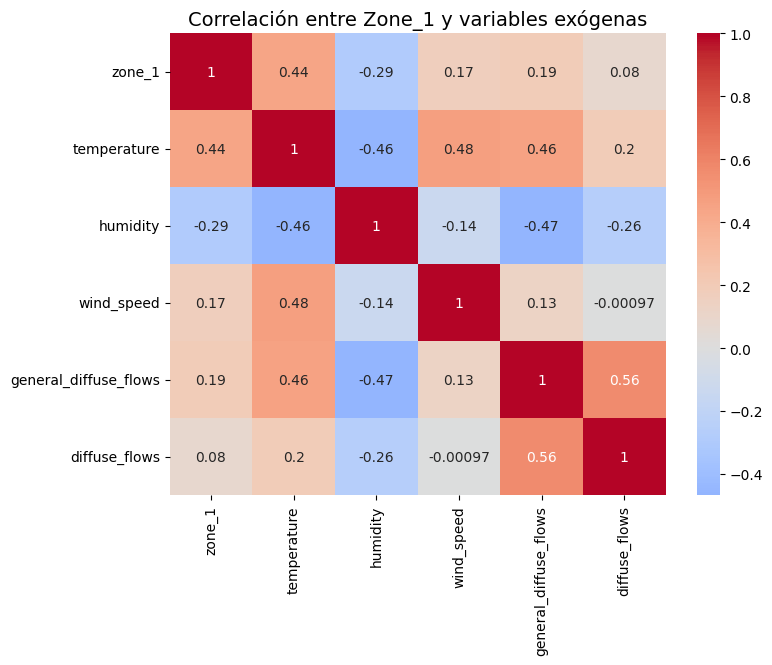

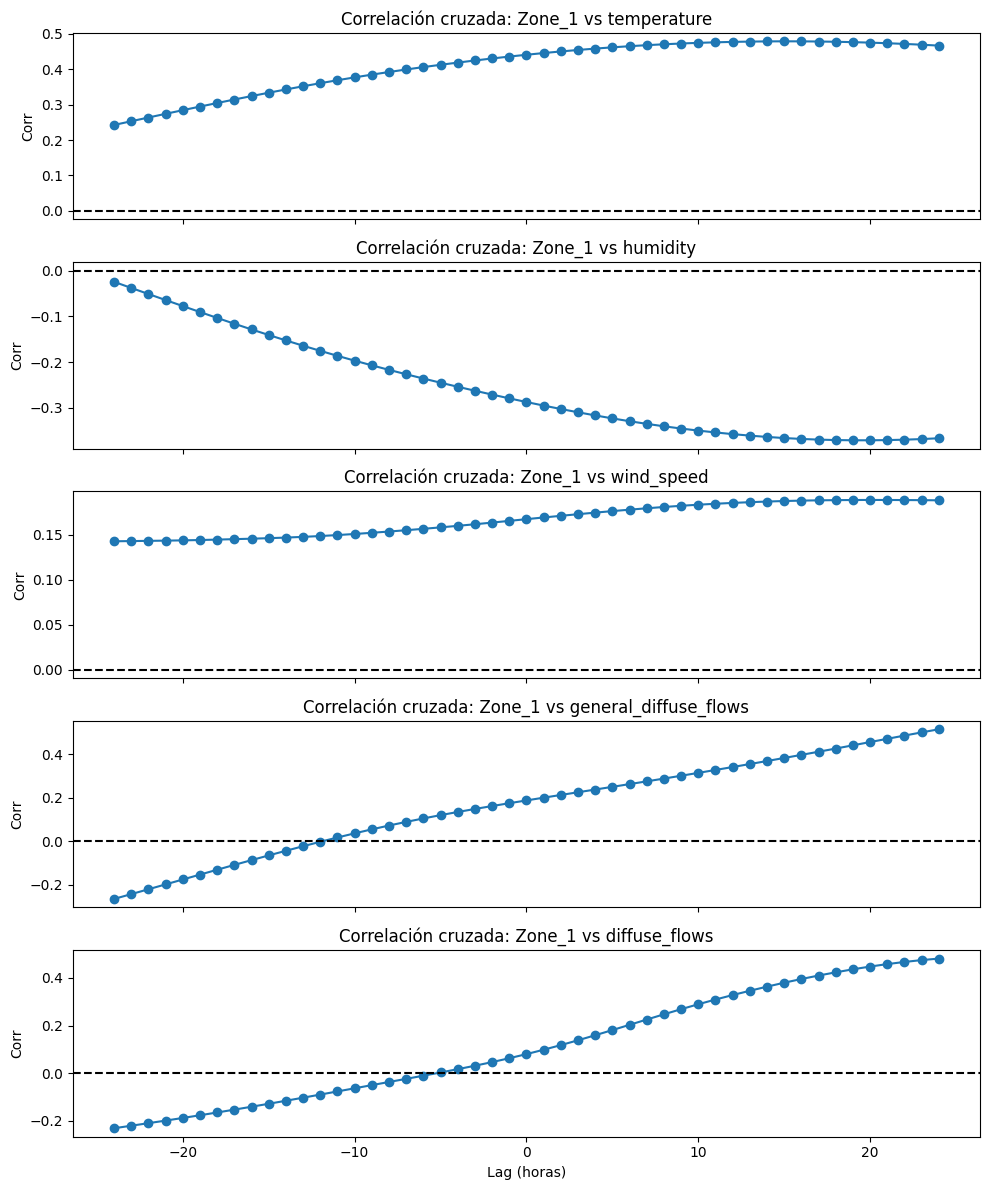

Correlaciones simples con Zone_1:
temperature              0.440221
humidity                -0.287421
general_diffuse_flows    0.187965
wind_speed               0.167444
diffuse_flows            0.080274
Name: zone_1, dtype: float64


In [9]:
# Filtramos sólo las variables relevantes
# Consumo zona elegida (zone_1) y variables climáticas
variables = ["temperature", "humidity", "wind_speed", "general_diffuse_flows", "diffuse_flows"]
df_zone1 = df[["zone_1"] + variables].copy()

# ------------------------------
# 1. Correlaciones simples
# ------------------------------
corr_matrix = df_zone1.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlación entre Zone_1 y variables exógenas", fontsize=14)
plt.show()

# ------------------------------
# 2. Correlación cruzada (lagged)
# ------------------------------
def cross_correlation(series1, series2, max_lag=24):
    """
    Calcula correlación cruzada hasta un lag máximo
    """
    lags = range(-max_lag, max_lag+1)
    correlations = [series1.corr(series2.shift(lag)) for lag in lags]
    return pd.DataFrame({"Lag": lags, "Correlation": correlations})

# Evaluamos cada variable exógena frente a zone_1
results = {}
for var in variables:
    results[var] = cross_correlation(df_zone1["zone_1"], df_zone1[var])

# Graficamos correlación cruzada
fig, axes = plt.subplots(len(variables), 1, figsize=(10, 12), sharex=True)
for i, var in enumerate(variables):
    axes[i].plot(results[var]["Lag"], results[var]["Correlation"], marker="o")
    axes[i].axhline(0, color="black", linestyle="--")
    axes[i].set_title(f"Correlación cruzada: Zone_1 vs {var}")
    axes[i].set_ylabel("Corr")
plt.xlabel("Lag (horas)")
plt.tight_layout()
plt.show()

# ------------------------------
# 3. Guardar correlaciones simples para análisis
# ------------------------------
corr_with_zone1 = corr_matrix["zone_1"].drop("zone_1").sort_values(key=abs, ascending=False)
print("Correlaciones simples con Zone_1:")
print(corr_with_zone1)


El análisis de correlación simple y cruzada permitió identificar que las variables exógenas con mayor poder explicativo sobre la demanda en Zone_1 son la temperatura y la humedad, debido a sus correlaciones significativas (0.44 y -0.29, respectivamente). Estos resultados sugieren que las condiciones térmicas del ambiente influyen de manera directa en el consumo energético, principalmente a través del uso de sistemas de climatización.

Adicionalmente, la variable general diffuse flows presenta una correlación moderada (0.18), lo cual indica que la radiación difusa también impacta, aunque en menor medida, en los patrones de consumo, probablemente por su relación con la iluminación natural y la climatología.

En contraste, variables como wind speed y diffuse flows mostraron correlaciones débiles (< 0.17), por lo que su inclusión en el modelo no resulta prioritaria.

En consecuencia, las variables exógenas más adecuadas para el modelado de Zone_1 son: temperatura, humedad y general diffuse flows.

---

#### **Elección de Métrica de error**

Para la evaluación del desempeño de los modelos predictivos aplicados sobre la serie temporal de consumo energético, se seleccionaron las métricas **Symmetric Mean Absolute Percentage Error (sMAPE)** y **Weighted Absolute Percentage Error (WAPE)**, por considerarse las más apropiadas en este contexto.

En primer lugar, la serie bajo análisis presenta **alta frecuencia de muestreo (10 minutos), estacionalidad intradía marcada y ocasionales valores bajos de consumo**. Estas características hacen que métricas como el **MAPE** puedan resultar inestables o poco representativas en presencia de valores cercanos a cero, lo que podría sobredimensionar el error. En este sentido, **sMAPE** se constituye en una alternativa robusta al ser simétrica respecto a sobreestimaciones y subestimaciones, y al normalizar el error en función de la magnitud tanto del valor real como del estimado. De esta manera, proporciona una medida porcentual interpretable, coherente y menos sesgada para comparar el rendimiento del modelo en cada instante de tiempo.

Por otra parte, el **WAPE** aporta una perspectiva complementaria al evaluar el error en términos del **peso relativo de las desviaciones absolutas frente al consumo total observado**. Esta métrica es operativamente relevante para el dominio energético, pues cuantifica de forma directa qué proporción del consumo total fue incorrectamente estimada, entregando así una medida agregada de la eficiencia global del pronóstico.

La combinación de ambas métricas permite abordar el análisis desde dos ángulos:

* **sMAPE:** precisión relativa a nivel individual (observación a observación), capturando el ajuste del modelo en diferentes tramos de la serie.
* **WAPE:** precisión acumulada global, evaluando la calidad del pronóstico de manera agregada y práctica para la toma de decisiones.

En conjunto, estas métricas ofrecen una evaluación **equilibrada, robusta y alineada con los objetivos del estudio**, validando la capacidad del modelo para capturar patrones de consumo energético y generar pronósticos confiables en horizontes de corto plazo.


---